In [ ]:
!pip install indic-nlp-library

In [ ]:
import tqdm
import logging

from dataclasses import dataclass
from typing import Optional, List, Any, Union
from transformers import PreTrainedTokenizer


logger = logging.getLogger(__name__)


@dataclass
class TextExample:
    """
    A single training/test example for simple sequence classification.
    Args:
        guid: Unique id for the example.
        text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
        text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
        label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
    """
    guid: str
    text_a: str
    text_b: Optional[str] = None
    label: Optional[str] = None

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(dataclasses.asdict(self), indent=2) + "\n"


@dataclass(frozen=True)
class MultipleChoiceExample:
    """
    A single training/test example for multiple choice

    Args:
        example_id: Unique id for the example.
        question: string. The untokenized text of the second sequence
        (question).
        contexts: list of str. The untokenized text of the first sequence
        (context of corresponding question).
        endings: list of str. multiple choice's options. Its length must be
        equal to contexts' length.
        label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
    example_id: str
    question: str
    contexts: List[str]
    endings: List[str]
    label: Optional[str]


@dataclass
class TokensExample:
    """
    A single training/test example for token classification.

    Args:
        guid: Unique id for the example.
        words: list. The words of the sequence.
        labels: (Optional) list. The labels for each word of the sequence. This
        should be specified for train and dev examples, but not for test
        examples.
    """
    guid: str
    words: List[str]
    labels: Optional[List[str]]


@dataclass
class InputFeatures:
    """
    A single set of features of data.
    Property names are the same names as the corresponding inputs to a model.
    """
    input_ids: Any
    attention_mask: Any
    token_type_ids: Any = None
    label: Any = None
    candidates: Any = None
    example_id: str = None


def convert_multiple_choice_examples_to_features(
    examples: List[MultipleChoiceExample],
    tokenizer: PreTrainedTokenizer,
    max_length: int,
    label_list: List[str],
    pad_token_segment_id=0,
    pad_on_left=False,
    pad_token=0,
    mask_padding_with_zero=True,
) -> List[InputFeatures]:
    """
    Loads a data file into a list of `InputFeatures`
    """

    label_map = {label: i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in tqdm.tqdm(enumerate(examples), desc="convert examples to features"):
        if ex_index % 10000 == 0:
            logger.info("Writing example %d of %d" % (ex_index, len(examples)))
        choices_inputs = []
        for ending_idx, (context, ending) in enumerate(zip(example.contexts, example.endings)):
            text_a = context
            if example.question.find("_") != -1:
                # this is for cloze question
                text_b = example.question.replace("_", ending)
            else:
                text_b = example.question + " " + ending

            inputs = tokenizer(
                text_a,
                text_b,
                add_special_tokens=True,
                max_length=max_length,
                truncation='longest_first',
                pad_to_max_length=True,
            )
            if "num_truncated_tokens" in inputs and inputs["num_truncated_tokens"] > 0:
                logger.info(
                    "Attention! you are cropping tokens (swag task is ok). "
                    "If you are training ARC and RACE and you are poping question + options,"
                    "you need to try to use a bigger max seq length!"
                )

            choices_inputs.append(inputs)

        label = label_map[example.label]

        input_ids = [x["input_ids"] for x in choices_inputs]
        attention_mask = (
            [x["attention_mask"] for x in choices_inputs] if "attention_mask" in choices_inputs[0] else None
        )
        token_type_ids = (
            [x["token_type_ids"] for x in choices_inputs] if "token_type_ids" in choices_inputs[0] else None
        )

        features.append(
            InputFeatures(
                example_id=example.example_id,
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                label=label,
            )
        )

    for f in features[:2]:
        logger.info("*** Example ***")
        logger.info("feature: %s" % f)

    return features


def convert_tokens_examples_to_features(
    examples: List[TokensExample],
    label_list: List[str],
    max_seq_length: int,
    tokenizer: PreTrainedTokenizer,
    cls_token_at_end=False,
    cls_token='[CLS]',
    cls_token_segment_id=1,
    sep_token='[SEP]',
    sep_token_extra=False,
    pad_on_left=False,
    pad_token=0,
    pad_token_segment_id=0,
    pad_token_label_id=-100,
    sequence_a_segment_id=0,
    mask_padding_with_zero=True,
) -> List[InputFeatures]:
    """ Loads a data file into a list of `InputFeatures`
        `cls_token_at_end` define the location of the CLS token:
            - False (Default, BERT/XLM pattern): [CLS] + A + [SEP] + B + [SEP]
            - True (XLNet/GPT pattern): A + [SEP] + B + [SEP] + [CLS]
        `cls_token_segment_id` define the segment id associated to the CLS token (0 for BERT, 2 for XLNet)
    """
    # TODO clean up all this to leverage built-in features of tokenizers

    label_map = {label: i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        if ex_index % 10_000 == 0:
            logger.info("Writing example %d of %d", ex_index, len(examples))

        tokens = []
        label_ids = []
        for word, label in zip(example.words, example.labels):
            word_tokens = tokenizer.tokenize(word)

            # bert-base-multilingual-cased sometimes output "nothing ([]) when calling tokenize with just a space.
            if len(word_tokens) > 0:
                tokens.extend(word_tokens)
                # Use the real label id for the first token of the word, and padding ids for the remaining tokens
                label_ids.extend([label_map[label]] + [pad_token_label_id] * (len(word_tokens) - 1))

        # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
        special_tokens_count = tokenizer.num_special_tokens_to_add()
        if len(tokens) > max_seq_length - special_tokens_count:
            tokens = tokens[: (max_seq_length - special_tokens_count)]
            label_ids = label_ids[: (max_seq_length - special_tokens_count)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids:   0   0  0    0    0     0       0   0   1  1  1  1   1   1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids:   0   0   0   0  0     0   0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens += [sep_token]
        label_ids += [pad_token_label_id]
        if sep_token_extra:
            # roberta uses an extra separator b/w pairs of sentences
            tokens += [sep_token]
            label_ids += [pad_token_label_id]
        segment_ids = [sequence_a_segment_id] * len(tokens)

        if cls_token_at_end:
            tokens += [cls_token]
            label_ids += [pad_token_label_id]
            segment_ids += [cls_token_segment_id]
        else:
            tokens = [cls_token] + tokens
            label_ids = [pad_token_label_id] + label_ids
            segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            input_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + input_mask
            segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
            label_ids = ([pad_token_label_id] * padding_length) + label_ids
        else:
            input_ids += [pad_token] * padding_length
            input_mask += [0 if mask_padding_with_zero else 1] * padding_length
            segment_ids += [pad_token_segment_id] * padding_length
            label_ids += [pad_token_label_id] * padding_length

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        assert len(label_ids) == max_seq_length

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s", example.guid)
            logger.info("tokens: %s", " ".join([str(x) for x in tokens]))
            logger.info("input_ids: %s", " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s", " ".join([str(x) for x in input_mask]))
            logger.info("segment_ids: %s", " ".join([str(x) for x in segment_ids]))
            logger.info("label_ids: %s", " ".join([str(x) for x in label_ids]))

        if "token_type_ids" not in tokenizer.model_input_names:
            segment_ids = None

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=input_mask, token_type_ids=segment_ids, label=label_ids
            )
        )
    return features


def convert_text_examples_to_features(
    examples: List[TextExample],
    tokenizer: PreTrainedTokenizer,
    max_length: Optional[int] = None,
    label_list=None,
    output_mode=None,
):
    if max_length is None:
        max_length = tokenizer.model_max_length

    label_map = {label: i for i, label in enumerate(label_list)}

    def label_from_example(example: TextExample) -> Union[int, float, None]:
        if example.label is None:
            return None
        if output_mode == "classification":
            return label_map[example.label]
        elif output_mode == "regression":
            return float(example.label)
        raise KeyError(output_mode)

    labels = [label_from_example(example) for example in examples]

    batch_encoding = tokenizer(
        [example.text_a if example.text_b is None else (example.text_a, example.text_b) for example in examples],
        max_length=max_length,
        padding="max_length",
        truncation=True,
    )

    features = []
    for i in range(len(examples)):
        inputs = {k: batch_encoding[k][i] for k in batch_encoding}

        feature = InputFeatures(**inputs, label=labels[i])
        features.append(feature)

    return features

In [ ]:
import csv
import json
import os

#from .examples import MultipleChoiceExample, TextExample, TokensExample


class DataProcessor:
    """Base class for data converters for sequence classification data sets."""

    def __init__(self, data_dir):
        self.data_dir = data_dir

    def get_examples(self, lang, mode):
        if mode == 'train':
            return self.get_train_examples(lang)
        elif mode == 'dev':
            return self.get_dev_examples(lang)
        elif mode == 'test':
            return self.get_test_examples(lang)

    def modes(self):
        return ['train', 'dev', 'test']

    def get_train_examples(self, lang):
        """Gets a collection of :class:`InputExample` for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, lang):
        """Gets a collection of :class:`InputExample` for the dev set."""
        raise NotImplementedError()

    def get_test_examples(self, lang):
        """Gets a collection of :class:`InputExample` for the test set."""
        raise NotImplementedError()

    def get_labels(self, lang):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def read_csv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, encoding='utf-8') as fp:
            return list(csv.reader(fp, delimiter=','))

    @classmethod
    def read_json(cls, input_file):
        """Reads a json file file."""
        with open(input_file, encoding='utf-8') as fp:
            return json.load(fp)

    @classmethod
    def readlines(cls, filepath):
        with open(filepath, encoding='utf-8') as fp:
            return fp.readlines()

    @classmethod
    def read_jsonl(cls, filepath):
        with open(filepath, 'r', encoding='utf-8') as fp:
            data = fp.readlines()
            data = list(map(lambda l: json.loads(l), data))
        return data


class IndicNLPHeadlines(DataProcessor):
    """Processor for the Headline Predction dataset"""

    def __init__(self, data_dir):
        self.data_dir = data_dir

    def get_train_examples(self, lang):
        """See base class."""
        fname = '{}/{}-train.json'.format(lang, lang)
        fpath = os.path.join(self.data_dir, fname)
        return self._create_examples(self.read_json(fpath), 'train')

    def get_dev_examples(self, lang):
        '''See base class.'''
        fname = '{}/{}-valid.json'.format(lang, lang)
        fpath = os.path.join(self.data_dir, fname)
        return self._create_examples(self.read_json(fpath), 'dev')

    def get_test_examples(self, lang):
        '''See base class.'''
        fname = '{}/{}-test.json'.format(lang, lang)
        fpath = os.path.join(self.data_dir, fname)
        return self._create_examples(self.read_json(fpath), 'test')

    def get_labels(self, lang):
        """See base class."""
        return ['A', 'B', 'C', 'D']

    def _create_examples(self, items, set_type):
        """Creates examples for the training and dev sets."""
        examples = [
            MultipleChoiceExample(
                example_id=idx,
                question='',
                contexts=[item['content'], item['content'], item['content'],
                          item['content']],
                endings=[item['optionA'], item['optionB'], item['optionC'],
                         item['optionD']],
                label=item['correctOption'],
            )
            for idx, item in enumerate(items)
        ]
        return examples


class WikiCloze(DataProcessor):
    """Processor for Wiki Cloze QA dataset"""

    def __init__(self, data_dir):
        self.data_dir = data_dir

    def modes(self):
        return ['test']

    def get_test_examples(self, lang):
        """See base class."""
        fname = '{}.json'.format(lang, lang)
        fpath = os.path.join(self.data_dir, fname)
        return self._create_examples(self.read_json(fpath)['cloze_data'], 'test')

    def get_labels(self, lang):
        """See base class."""
        return list(range(4))

    def _create_examples(self, items, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, item) in enumerate(items):
            if '' in [option.strip() for option in item['options']]:
                continue
            example = MultipleChoiceExample(
                example_id=i,
                question=item['question'].replace('<MASK>', '[MASK]'),
                contexts=[],
                endings=item['options'],
                label=item['options'].index(item['answer'])
            )
            examples.append(example)
        return examples


class IndicNLPGenre(DataProcessor):
    """Processor for the Article Genre Classification data set"""

    def __init__(self, data_dir):
        self.data_dir = data_dir

    def get_train_examples(self, lang):
        """See base class."""
        fname = '{}/{}-train.csv'.format(lang, lang)
        fpath = os.path.join(self.data_dir, fname)
        return self._create_examples(self.read_csv(fpath), 'train')

    def get_dev_examples(self, lang):
        """See base class."""
        fname = '{}/{}-valid.csv'.format(lang, lang)
        fpath = os.path.join(self.data_dir, fname)
        return self._create_examples(self.read_csv(fpath), 'dev')

    def get_test_examples(self, lang):
        fname = '{}/{}-test.csv'.format(lang, lang)
        fpath = os.path.join(self.data_dir, fname)
        return self._create_examples(self.read_csv(fpath), 'test')

    def get_labels(self, lang):
        """See base class."""
        filename = '{}/{}-train.csv'.format(lang, lang)
        lines = self.read_csv(os.path.join(self.data_dir, filename))
        labels = map(lambda l: l[0], lines)
        labels = list(set(labels))
        return labels

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            example = TextExample(
                guid=('%s-%s' % (set_type, i)),
                text_a=line[1],
                label=line[0]
            )
            examples.append(example)
        return examples


class WikiNER(DataProcessor):

    def __init__(self, data_dir):
        self.data_dir = data_dir

    def get_examples(self, lang, mode):
        mode = 'valid' if mode == 'dev' else mode
        file_path = os.path.join(self.data_dir, lang, f'{mode}.txt')
        guid_index = 1
        examples = []
        with open(file_path, encoding='utf-8') as f:
            words = []
            labels = []
            for line in f:
                if line.startswith('-DOCSTART-') or line == '' or line == '\n':
                    if words:
                        example = TokensExample(
                            guid=f'{mode}-{guid_index}',
                            words=words,
                            labels=labels
                        )
                        examples.append(example)
                    guid_index += 1
                    words = []
                    labels = []
                else:
                    splits = line.split(' ')
                    words.append(splits[0])
                    if len(splits) > 1:
                        labels.append(splits[-1].replace('\n', ''))
                    else:
                        # Examples could have no label for mode = 'test'
                        labels.append('O')
            if words:
                example = TokensExample(
                    guid=f'{mode}-{guid_index}',
                    words=words,
                    labels=labels
                )
                examples.append(example)
        return examples

    def get_labels(self, lang):
        path = os.path.join(self.data_dir, lang, 'labels.txt')
        with open(path, 'r') as f:
            labels = f.read().splitlines()
        if 'O' not in labels:
            labels = ['O'] + labels
        return labels


class WikiSectionTitles(DataProcessor):
    """Processor for the Wikipedia Section Title Prediction dataset"""

    def __init__(self, data_dir):
        self.data_dir = data_dir

    def get_train_examples(self, lang):
        """See base class."""
        fname = '{}/{}-train.json'.format(lang, lang)
        fpath = os.path.join(self.data_dir, fname)
        return self._create_examples(self.read_json(fpath), 'train')

    def get_dev_examples(self, lang):
        """See base class."""
        fname = '{}/{}-valid.json'.format(lang, lang)
        fpath = os.path.join(self.data_dir, fname)
        return self._create_examples(self.read_json(fpath), 'dev')

    def get_test_examples(self, lang):
        """See base class."""
        fname = '{}/{}-test.json'.format(lang, lang)
        fpath = os.path.join(self.data_dir, fname)
        return self._create_examples(self.read_json(fpath), 'test')

    def get_labels(self, lang):
        """See base class."""
        return ['titleA', 'titleB', 'titleC', 'titleD']

    def _create_examples(self, items, set_type):
        """Creates examples for the training and dev sets."""
        examples = [
            MultipleChoiceExample(
                example_id=idx,
                question='',
                contexts=[item['sectionText'], item['sectionText'],
                          item['sectionText'], item['sectionText']],
                endings=[item['titleA'], item['titleB'], item['titleC'],
                         item['titleD']],
                label=item['correctTitle'],
            )
            for idx, item in enumerate(items)
        ]
        return examples


class ManKiBaat(DataProcessor):
    """Processor for Man ki Baat dataset"""

    def __init__(self, data_dir):
        self.data_dir = data_dir

    def modes(self):
        return ['en', 'in']

    def get_examples(self, lang, mode):
        if mode == 'en':
            return self.get_examples_en(lang)
        elif mode == 'in':
            return self.get_examples_in(lang)

    def get_examples_en(self, lang):
        """Get examples of English language"""
        fname = 'en-{}/mkb.en'.format(lang)
        fpath = os.path.join(self.data_dir, fname)
        return self._create_examples(self.readlines(fpath), 'en')

    def get_examples_in(self, lang):
        """Get examples of the Indian language"""
        fname = 'en-{}/mkb.{}'.format(lang, lang)
        fpath = os.path.join(self.data_dir, fname)
        return self._create_examples(self.readlines(fpath), 'in')

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            example = TextExample(
                guid=('%s-%s' % (set_type, i)),
                text_a=line,
                label=i
            )
            examples.append(example)
        return examples

    def get_labels(self, lang):
        # return dummy value greater than number of examples
        return list(range(10000))


class ACTSA(IndicNLPGenre):
    pass


class BBCNews(IndicNLPGenre):

    def get_dev_examples(self, lang):
        """See base class."""
        fname = '{}/{}-test.csv'.format(lang, lang)
        fpath = os.path.join(self.data_dir, fname)
        return self._create_examples(self.read_csv(fpath), 'dev')


class INLTKHeadlines(IndicNLPGenre):
    pass


class SohamArticles(IndicNLPGenre):
    pass


class IITPMovies(IndicNLPGenre):
    pass


class IITProducts(IndicNLPGenre):
    pass


class AmritaParaphraseExact(IndicNLPGenre):

    def get_dev_examples(self, lang):
        """See base class."""
        fname = '{}/{}-test.csv'.format(lang, lang)
        fpath = os.path.join(self.data_dir, fname)
        return self._create_examples(self.read_csv(fpath), 'dev')

    def get_labels(self, lang):
        """See base class."""
        filename = '{}/{}-train.csv'.format(lang, lang)
        lines = self.read_csv(os.path.join(self.data_dir, filename))
        labels = map(lambda l: l[2], lines)
        labels = list(set(labels))
        return labels

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            example = TextExample(
                guid=('%s-%s' % (set_type, i)),
                text_a=line[0],
                text_b=line[1],
                label=line[2]
            )
            examples.append(example)
        return examples


class AmritaParaphraseFuzzy(AmritaParaphraseExact):
    pass


class MidasDiscourse(DataProcessor):
    """Processor for the Article Genre Classification data set"""

    def __init__(self, data_dir):
        self.data_dir = data_dir

    def get_train_examples(self, lang):
        """See base class."""
        fname = '{}/train.json'.format(lang, lang)
        fpath = os.path.join(self.data_dir, fname)
        return self._create_examples(self.read_json(fpath), 'train')

    def get_dev_examples(self, lang):
        """See base class."""
        fname = '{}/val.json'.format(lang, lang)
        fpath = os.path.join(self.data_dir, fname)
        return self._create_examples(self.read_json(fpath), 'dev')

    def get_test_examples(self, lang):
        fname = '{}/test.json'.format(lang, lang)
        fpath = os.path.join(self.data_dir, fname)
        return self._create_examples(self.read_json(fpath), 'test')

    def get_labels(self, lang):
        """See base class."""
        filename = '{}/train.json'.format(lang, lang)
        lines = self.read_json(os.path.join(self.data_dir, filename))
        labels = map(lambda l: l['Discourse Mode'], lines)
        labels = list(set(labels))
        return labels

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            example = TextExample(
                guid=('%s-%s' % (set_type, i)),
                text_a=line['Sentence'],
                label=line['Discourse Mode']
            )
            examples.append(example)
        return examples


class WNLI(DataProcessor):
    """Processor for the WNLI data set (GLUE version)."""

    def __init__(self, data_dir):
        self.data_dir = data_dir

    def get_train_examples(self, lang):
        """See base class."""
        fname = '{}/train.csv'.format(lang)
        fpath = os.path.join(self.data_dir, fname)
        return self._create_examples(self.read_csv(fpath), 'train')

    def get_dev_examples(self, lang):
        """See base class."""
        fname = '{}/dev.csv'.format(lang)
        fpath = os.path.join(self.data_dir, fname)
        return self._create_examples(self.read_csv(fpath), 'dev')

    def get_test_examples(self, lang):
        """See base class."""
        fname = '{}/dev.csv'.format(lang)
        fpath = os.path.join(self.data_dir, fname)
        return self._create_examples(self.read_csv(fpath), 'test')

    def get_labels(self, lang):
        """See base class."""
        return ['0', '1']

    def _create_examples(self, lines, set_type):
        """Creates examples for the training, dev and test sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, line[0])
            text_a = line[1]
            text_b = line[2]
            label = line[-1]
            examples.append(TextExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
        return examples


class COPA(DataProcessor):
    """Processor for the Wikipedia Section Title Prediction dataset"""

    def __init__(self, data_dir):
        self.data_dir = data_dir

    def get_train_examples(self, lang):
        """See base class."""
        fname = '{}/train.jsonl'.format(lang)
        fpath = os.path.join(self.data_dir, fname)
        return self._create_examples(self.read_jsonl(fpath), 'train')

    def get_dev_examples(self, lang):
        """See base class."""
        fname = '{}/val.jsonl'.format(lang)
        fpath = os.path.join(self.data_dir, fname)
        return self._create_examples(self.read_jsonl(fpath), 'dev')

    def get_test_examples(self, lang):
        """See base class."""
        fname = '{}/val.jsonl'.format(lang, lang)
        fpath = os.path.join(self.data_dir, fname)
        return self._create_examples(self.read_jsonl(fpath), 'test')

    def get_labels(self, lang):
        """See base class."""
        return [0, 1]

    def _create_examples(self, items, set_type):
        """Creates examples for the training and dev sets."""
        examples = [
            MultipleChoiceExample(
                example_id=idx,
                question='',
                contexts=[item['premise'], item['premise']],
                endings=[item['choice1'], item['choice2']],
                label=item['label'],
            )
            for idx, item in enumerate(items)
        ]
        return examples

In [ ]:
df_train.iloc[0]

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
import json
import csv
f=open('/kaggle/input/inlpprojectdata/wiki-cloze/wiki-cloze/hi_sample.json')
data=json.load(f)
f.close()

In [2]:
data['cloze_data'][0]

TypeError: list indices must be integers or slices, not str

In [4]:
len(data)

3

In [5]:
f=open('/kaggle/input/inlpprojectdata/wiki-cloze/wiki-cloze/hi.json')
data=json.load(f)
f.close()

In [ ]:
dp=DataProcessor('/kaggle/input/inlpprojectdata/wiki-cloze/wiki-cloze/hi_sample.json')

In [ ]:
wc=WikiCloze(dp)

In [ ]:
wc._create_examples()

In [6]:
lst_q=[i['question'] for i in data['cloze_data']]

In [7]:
lst_a=[i['answer'] for i in data['cloze_data']]
lst_c=[i['options'] for i in data['cloze_data']]

In [8]:
data['cloze_data'][0]

{'question': '1 अक्षांश उत्तर (1st parallel north) <MASK> की भूमध्यरेखा के उत्तर में 1 अक्षांश पर स्थित अक्षांश वृत्त है। यह काल्पनिक रेखा हिन्द महासागर, प्रशांत महासागर व अटलांटिक महासागर और दक्षिण अमेरिका, दक्षिणपूर्वी एशिया (मलेशिया, इंडोनेशिया, इत्यादि) व अफ़्रीका के भूमीय क्षेत्रों से निकलती है।',
 'answer': 'पृथ्वी',
 'category': 'LOC',
 'title': '1 अक्षांश उत्तर',
 'out_of_context_options': ['जहाजपुर'],
 'options': ['जहाजपुर', 'पृथ्वी', 'अक्षांश', 'अफ़्रीका']}

In [9]:
import pandas as pd
import numpy as np
z=pd.DataFrame.from_dict({'question':lst_q,'correct_answer':lst_a,'options':lst_c})

In [10]:
z=z.sample(frac=1)
idd=28000
df_train=z[:idd]
df_test=z[idd:]


In [11]:
import matplotlib.pyplot as plt

import torch
from torch import nn,tensor
from torch.utils.data import Dataset,DataLoader
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm
import re
import numpy as np
import pandas as pd
import pickle
from indicnlp.tokenize import indic_tokenize
import seaborn as sns

train_path = '/content/drive/MyDrive/Colab Notebooks/INLP Project/product_reviews/hi/hi-train.csv'
test_path ='/content/drive/MyDrive/Colab Notebooks/INLP Project/product_reviews/hi/hi-test.csv'
val_path = '/content/drive/MyDrive/Colab Notebooks/INLP Project/product_reviews/hi/hi-valid.csv'
backward_model_path ='/kaggle/input/inlpprojectdata/pretrained_backward_model'
forward_model_path ='/kaggle/input/inlpprojectdata/pretrained_forward_model'
word_to_ix_path = '/kaggle/input/inlpprojectdata/word_to_ix.pkl'

In [12]:

"""train_df = pd.read_csv(train_path, header=None, names=['Label', 'Text'])

test_df = pd.read_csv(test_path, header=None, names=['Label', 'Text'])
train_df.head()

"""

"train_df = pd.read_csv(train_path, header=None, names=['Label', 'Text'])\n\ntest_df = pd.read_csv(test_path, header=None, names=['Label', 'Text'])\ntrain_df.head()\n\n"

In [13]:
"""from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_df['Label'] = label_encoder.fit_transform(train_df['Label'])
test_df['Label'] = label_encoder.transform(test_df['Label'])
test_df.head()"""


"from sklearn.preprocessing import LabelEncoder\n\nlabel_encoder = LabelEncoder()\ntrain_df['Label'] = label_encoder.fit_transform(train_df['Label'])\ntest_df['Label'] = label_encoder.transform(test_df['Label'])\ntest_df.head()"

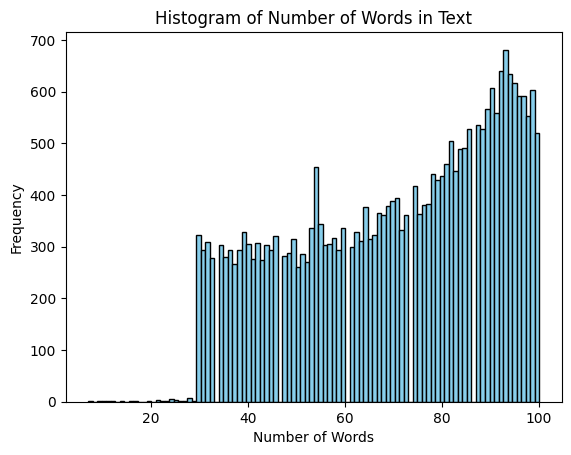

In [14]:

text_word_counts = df_train['question'].apply(lambda x: len(x.split()))

plt.hist(text_word_counts, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Words in Text')
plt.show()


(array([3.000e+00, 5.000e+00, 2.000e+00, 5.000e+00, 1.200e+01, 1.200e+01,
        1.203e+03, 8.770e+02, 1.194e+03, 1.162e+03, 8.950e+02, 1.148e+03,
        1.405e+03, 1.218e+03, 9.660e+02, 1.325e+03, 1.494e+03, 1.087e+03,
        1.544e+03, 1.764e+03, 1.930e+03, 1.590e+03, 2.371e+03, 2.522e+03,
        2.266e+03]),
 array([  7.  ,  10.72,  14.44,  18.16,  21.88,  25.6 ,  29.32,  33.04,
         36.76,  40.48,  44.2 ,  47.92,  51.64,  55.36,  59.08,  62.8 ,
         66.52,  70.24,  73.96,  77.68,  81.4 ,  85.12,  88.84,  92.56,
         96.28, 100.  ]),
 <BarContainer object of 25 artists>)

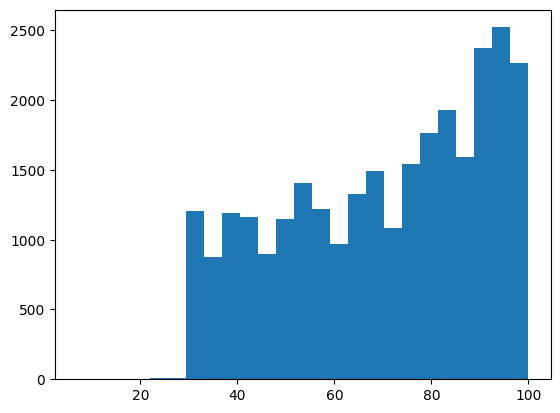

In [15]:
plt.hist(text_word_counts,bins=25)

Set mxlen as 388

In [16]:
class ElmoProcessor(torch.nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,wt_mat):
        super(ElmoProcessor,self).__init__()
        #self.embeddings=nn.Embedding(vocab_size,embedding_dim)
        self.lstmf1=nn.LSTM(embedding_dim,hidden_dim,num_layers=1,bidirectional=False,batch_first=True)
        self.lstmf2=nn.LSTM(hidden_dim,hidden_size=hidden_dim,bidirectional=False,batch_first=True)
        self.embedding=wt_mat.to(device)
        # self.lstmb1=nn.LSTM(embedding_dim,hidden_dim,num_layers=1,bidirectional=False,batch_first=True)
        # self.lstmb2=nn.LSTM(hidden_dim,hidden_size=hidden_dim,bidirectional=False,batch_first=True)

        self.linear=nn.Linear(hidden_dim,vocab_size)
    def forward(self,embeddingdata):
        emb=torch.tensor(self.embedding(embeddingdata.to(device)))

        emb_f=emb
        # emb_b=emb.flip(1)
        o1f1,h1f1=self.lstmf1(emb_f)
        o2f2,h2f2=self.lstmf2(o1f1)
        # o2f2=o2f2+o1f1
        # h2f2=h2f2+h1f1
        # o1b1,h1b1=self.lstmb1(emb_b)
        # o2b2,h2b2=self.lstmb2(o1b1,h1b1)
        # o2b2=o2b2+o1b1
        # h2b2=h2b2+h1b1

        # weighted_vector_emb=torch.cat([emb_f,emb_b],dim=2)
        # weighted_vector_h1=torch.cat([o1f1,o1f1],dim=2)
        # weighted_vector_h2=torch.cat([o1f1,o2f2],dim=2)
        output =self.linear(o2f2)
        return (output,o1f1,o2f2)

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"

wt_mat=torch.zeros(size=(90337,300))
embeddings=torch.tensor(wt_mat,dtype=torch.float)
forward_model= torch.load(forward_model_path,map_location=torch.device('cpu'))
backward_model= torch.load(backward_model_path,map_location=torch.device('cpu'))

/tmp/ipykernel_434/554395451.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings=torch.tensor(wt_mat,dtype=torch.float)


In [18]:
forward_model

ElmoProcessor(
  (lstmf1): LSTM(300, 300, batch_first=True)
  (lstmf2): LSTM(300, 300, batch_first=True)
  (embedding): Embedding(96236, 300, padding_idx=0)
  (linear): Linear(in_features=300, out_features=96236, bias=True)
)

In [19]:
with open(word_to_ix_path, 'rb') as file:

    word_to_ix = pickle.load(file)


In [20]:
len(list(word_to_ix.values()))

96236

In [21]:
list(word_to_ix.keys())[-1]

'कोयो'

In [22]:
df_train.columns

Index(['question', 'correct_answer', 'options'], dtype='object')

In [23]:
mxlen=[]
for column in df_train[df_train.columns[2]]:
    mxlen.append(len(column))
max(mxlen)

4

In [24]:
df_train[df_train.columns[0]]

18614    बर्लिन कांग्रेस (13 जून – 13 जुलाई 1878) <MASK...
28443    १७ जून २0१२ को <MASK> ने इस पर प्रकाशित एक आले...
23136    हरि सिंह का जन्म २३ सितम्बर १८९५ को अमर महल मे...
13052    <MASK> समेत लगभग सारे राष्ट्रमण्डल प्रजाभूमियो...
15442    <MASK>, नेमावर और हरदा के जैन श्रद्वालुओं के अ...
                               ...                        
25070    म्यांमार में भारतीय सैन्य अभियान 201510 जून को...
14178    दो रास्ते 1969 में बनी हिन्दी भाषा की फिल्म है...
3351     इंद्रप्रस्थ कॉलेज फॉर विमेन जिसे इंद्रप्रस्थ क...
17010    पेंगुइन (पीढ़ी स्फेनिस्कीफोर्मेस, प्रजाति स्फे...
26474    इस हरे-भरे टापू की शकल शंख जैसी है। कहते हैं, ...
Name: question, Length: 28000, dtype: object

In [26]:
len((413-45-1)*[word_to_ix['<PAD>']])

367

In [27]:
df_train.columns

Index(['question', 'correct_answer', 'options'], dtype='object')

In [28]:
df_train=df_train.reset_index(drop=True)

In [29]:
df_test=df_test.reset_index(drop=True)

In [30]:
class DatafetchClassify(Dataset):
    def __init__(self,split:str):
        sequence=[]
        labels=[]
        options=[]
        for x in tqdm(range(len(split[split.columns[2]])),desc='Generate next word prediction data'):
            #if len(split[split.columns[2]][x])<2 or split[split.columns[2]][x][0]=='=':continue
            data=split[split.columns[0]][x]
           # print(x)
            num=x
            z=split[split.columns[2]][num]
            a=split[split.columns[1]][num]
            words_data=indic_tokenize.trivial_tokenize(data,'hi')
            indices_words=[word_to_ix.get(i,1) for i in words_data[:100]]
            indices_option=[word_to_ix.get(i,1) for i in z]
            #print(z)
            indices_correct=word_to_ix.get(a,1)
            #sequence.append(indices_words+indices_option[0]+(100-len(indices_words)-len(indices_labels))*[word_to_ix['<PAD>']])
            lst=indices_words+(100-len(indices_words))*[word_to_ix['<PAD>']] 
            sequence.append(lst+indices_option)
            #sequence.append(lst)
            #options.append(indices_option)
            #lst_i=[indices_correct for i in range(4)]
            labels.append(z.index(a))
             # alternative: x.strip().split(' ')
        self.labels=tensor(labels)
        self.sequence=tensor(sequence)
        #print(self.labels.unsqueeze(0).t().shape,self.sequence.shape)
        #self.sequence=torch.cat([self.sequence,self.labels.unsqueeze(0).t()],dim=1)
        #self.sequence.to(device)
        #self.labels=tensor(labels)
        #self.labels.to(device)
    def __len__(self)->int:
        return len(self.sequence)
    def __getitem__(self,index:int):
        return self.sequence[index],self.labels[index]

In [31]:
classifier_dataset=DatafetchClassify(df_train)

Generate next word prediction data: 100%|██████████| 28000/28000 [00:06<00:00, 4093.34it/s]


In [32]:
'asdasd'

'asdasd'

In [33]:
word_to_ix['<PAD>']

0

In [34]:
batch_size=128

In [35]:
classifer_dataloader=DataLoader(classifier_dataset,batch_size,shuffle=True,pin_memory=False)
data,labels=next(iter(classifer_dataloader))


In [36]:
class ElmoClassifier(torch.nn.Module):
    def __init__(self,no_classes,forward_model,backward_model,embedding_dim):
        super(ElmoClassifier,self).__init__()
        self.forward_model=forward_model
        self.embedding = forward_model.embedding
        self.backward_model=backward_model
        self.forward_model.requires_grad=False
        self.backward_model.requires_grad=False
        self.linear1=nn.Linear(100,no_classes)
        #self.linear2=nn.Linear(50,no_classes)
        self.leakyrelu=nn.LeakyReLU()
        self.param0=nn.Parameter(torch.rand(1),requires_grad=True)
        self.param1=nn.Parameter(torch.rand(1),requires_grad=True)
        self.param2=nn.Parameter(torch.rand(1),requires_grad=True)
        self.bilstm=nn.LSTM(input_size=embedding_dim*2,hidden_size=50,bidirectional=True,batch_first=True)
    def forward(self,embdata):
        _,o1f1,o2f2=self.forward_model(embdata)
        _,o1b1,o2b2=self.backward_model(embdata)
        # print(embdata.shape)
        # print('\n',o1f1.shape)
        embdata = self.embedding(embdata)
        e = torch.cat([embdata, embdata],dim=2)
        h1=torch.cat([o1f1,o1b1.flip(1)],dim=2)
        h2=torch.cat([o2f2,o2b2.flip(1)],dim=2)
        bio,bih=self.bilstm(self.param0*e + self.param1*h1 +self.param2*h2)
        #print(bio[:,-1,:])
        y=self.linear1(self.leakyrelu(bio[:,-1,:]))
        #y=self.linear2(y)
        return y

In [37]:
len([word_to_ix.keys()])

1

In [38]:
classifier=ElmoClassifier(4,forward_model,backward_model,300)

In [39]:
classifier.to(device)
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(classifier.parameters(),5e-3)

In [40]:
#del classifier,loss_fn,optimizer,x_train,y_train
import gc
torch.cuda.empty_cache()
gc.collect()

96

In [41]:
#del classifier,optimizer,x_train,y_train,classifer_dataloader

In [42]:
for epoch in range(5):
    train_loss=0
    classifier.train()
    for batch in tqdm(classifer_dataloader,desc="Training"):
        x_train,y_train=batch
        optimizer.zero_grad()
        x_train.to(device)
        y_train.to(device)
        output=classifier(x_train.to(device))
        loss=loss_fn(output.to(device),y_train.to(device))
        del output
        loss.backward()
        optimizer.step()
        train_loss +=loss.item()
    print(train_loss)

Training:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_434/1007020132.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb=torch.tensor(self.embedding(embeddingdata.to(device)))
Training: 100%|██████████| 219/219 [01:10<00:00,  3.10it/s]


300.3475811481476


Training: 100%|██████████| 219/219 [01:09<00:00,  3.13it/s]


294.3661398887634


Training: 100%|██████████| 219/219 [01:09<00:00,  3.13it/s]


288.0450053215027


Training: 100%|██████████| 219/219 [01:09<00:00,  3.13it/s]


280.283154964447


Training: 100%|██████████| 219/219 [01:09<00:00,  3.13it/s]

268.2802859544754


In [43]:
classifier_eval=DatafetchClassify(df_test)

Generate next word prediction data: 100%|██████████| 7140/7140 [00:01<00:00, 4368.74it/s]


In [44]:
classifer_dataloader_eval=DataLoader(classifier_eval,batch_size=32,shuffle=False)
data,labels=next(iter(classifer_dataloader_eval))


In [45]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,f1_score,recall_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
confusion_matrix=np.zeros((len(word_to_ix.keys()),len(word_to_ix.keys())))
y_true=[]
y_pred=[]
train_loss=0.0
classifier.eval()
with torch.no_grad():
    for batch in tqdm(classifer_dataloader_eval,desc="Evaluation"):
        x_train,y_train=batch
        #optimizer.zero_grad()
        x_train.to(device)
        y_train.to(device)
        output=classifier(x_train.to(device))
        #print(output.shape)
        _,preds=torch.max(output,dim=1)
        #print(preds,y_train)
        #break
        y_true.extend(y_train.cpu().detach().numpy())
        y_pred.extend(preds.cpu().detach().numpy())
        for i in range(len(y_train)):
            confusion_matrix[y_train[i]][preds[i]]+=1

Evaluation:   0%|          | 0/224 [00:00<?, ?it/s]/tmp/ipykernel_434/1007020132.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb=torch.tensor(self.embedding(embeddingdata.to(device)))
Evaluation: 100%|██████████| 224/224 [00:16<00:00, 13.52it/s]


In [46]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.30      0.45      0.36      1761
           1       0.38      0.17      0.24      1795
           2       0.33      0.37      0.35      1826
           3       0.34      0.33      0.33      1758

    accuracy                           0.33      7140
   macro avg       0.34      0.33      0.32      7140
weighted avg       0.34      0.33      0.32      7140



In [1]:
import pandas as pd

data = {'precision': [0.30, 0.38, 0.33, 0.34],
        'recall': [0.45, 0.17, 0.37, 0.33],
        'f1-score': [0.36, 0.24, 0.35, 0.33],
        'support': [1761, 1795, 1826, 1758]}

df = pd.DataFrame(data, columns=['precision', 'recall', 'f1-score', 'support'])

# Add the row for accuracy
df.loc['accuracy'] = [0.00, 0.33, 0.00, 7140]

# Add the row for macro average
df.loc['macro avg'] = [0.34, 0.33, 0.32, 7140]

# Add the row for weighted average (already included in the data)
# df.loc['weighted avg'] = [0.34, 0.33, 0.32, 7140]

print(df)

           precision  recall  f1-score  support
0               0.30    0.45      0.36   1761.0
1               0.38    0.17      0.24   1795.0
2               0.33    0.37      0.35   1826.0
3               0.34    0.33      0.33   1758.0
accuracy        0.00    0.33      0.00   7140.0
macro avg       0.34    0.33      0.32   7140.0


<Axes: >

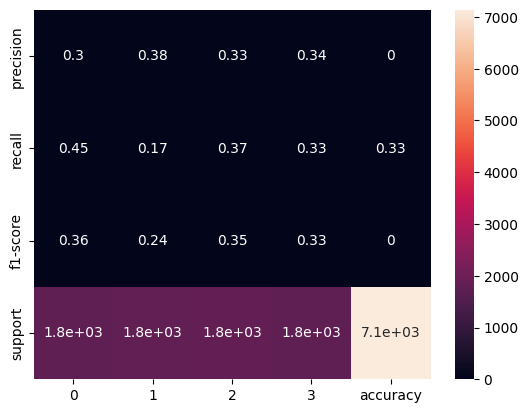

In [2]:
import seaborn as sns 
sns.heatmap(df.iloc[:-1,:].T,annot=True)

In [ ]:
sns.heatmap(confusion_matrix,annot=True)

In [ ]:
accuracy_score(y_true,y_pred)

In [ ]:
torch.save(classifier,'./clozeqanda_final')

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#predicted_classes = label_encoder.inverse_transform(y_pred)
#true_classes = label_encoder.inverse_transform(y_true)

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

target_names = label_encoder.classes_
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
# print(md5)

In [ ]:
# print(classifier)